<a href="https://colab.research.google.com/github/michael-borck/weatherwise-template/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


# Weather Advisor — Colab Notebook Table of Contents
**Sections (cells):**
1. Setup & Configuration (installs + imports)
2. Weather Data Functions (`get_weather_data`)
3. Visualization Functions (temperature + precipitation)
4. Natural Language Processing (parse & generate response)
5. UI (ipywidgets)
6. Main app orchestration
7. Testing & Example runs

> Note: This notebook prefers `fetch-my-weather` but will fall back to `wttr.in` JSON if the package isn't available.


## 📦 Setup and Configuration
Import required packages and setup environment.

In [22]:
!pip install fetch-my-weather ipywidgets pyinputplus python-dateutil
!pip install --upgrade jupyterlab_widgets


In [23]:
# Imports and configuration
import json
import requests
import math
from datetime import datetime, timezone
from dateutil import parser as dateparser
import re
import traceback

# plotting
import matplotlib.pyplot as plt

# ipywidgets for UI
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# safety: set matplotlib to inline display
%matplotlib inline

# Try to import fetch_my_weather wrapper (preferred). We'll abstract usage in get_weather_data.
try:
    import fetch_my_weather as fmw   # if the package name exists
    _FETCH_MY_WEATHER_AVAILABLE = True
except Exception:
    fmw = None
    _FETCH_MY_WEATHER_AVAILABLE = False


In [24]:
print("fetch-my-weather available:", _FETCH_MY_WEATHER_AVAILABLE)

fetch-my-weather available: True


In [29]:
from typing import Optional

def safe_get(d, *keys, default=None):
    """Return nested dict value safely (keys as path)."""
    try:
        for k in keys:
            d = d[k]
        return d
    except Exception:
        return default

def to_title(text: Optional[str]) -> str:
    """
    Converts a string to title case, handling None/empty inputs gracefully.

    Args:
        text (Optional[str]): The input string.

    Returns:
        str: The title-cased string, or an empty string if input is None.
    """
    return text.title() if text else ""


## 🌤️ Weather Data Functions

In [30]:
def get_weather_data(location, forecast_days=5, provider_preference='fetch-my-weather'):
    """
    Retrieve weather data for a specified location.
    Tries fetch-my-weather first (if installed); otherwise uses wttr.in json endpoint.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)
        provider_preference (str): 'fetch-my-weather' or 'wttr' (ignored if package not installed)

    Returns:
        dict: Normalised weather data including current conditions and list of daily forecasts.
              Format:
              {
                 'location': 'Name',
                 'current': { 'temp_C': float, 'condition': str, 'humidity': int, 'wind_kmph': float, ...},
                 'forecast': [
                     {'date': 'YYYY-MM-DD', 'maxtempC': float, 'mintempC': float, 'avgtempC': float, 'hourly': [...], 'precipMM': float, ...},
                     ...
                 ],
                 'source': 'fetch-my-weather'/'wttr'
              }

        On error returns {'error': '<message>'}
    """
    try:
        forecast_days = max(1, min(5, int(forecast_days)))
    except Exception:
        forecast_days = 5

    # 1) Try fetch-my-weather wrapper if available and preferred
    if _FETCH_MY_WEATHER_AVAILABLE and provider_preference == 'fetch-my-weather':
        try:
            # If the package is not compatible we fall back to wttr.in.
            try:
                result = fmw.fetch(location, format="raw_json")
            except AttributeError:
                result = fmw.get_weather(location, format="raw_json")
            # Attempt to normalise structure; if it fails raise to fallback
            if not result:
                raise RuntimeError("fetch-my-weather returned empty result")
            # If result is raw text/json - ensure we have dict
            if isinstance(result, str):
                try:
                    result = json.loads(result)
                except Exception:
                    raise RuntimeError("fetch-my-weather returned non-json response")
            current = safe_get(result, 'current_condition', 0) or safe_get(result, 'current') or {}
            forecast_raw = result.get('weather') or result.get('forecast') or []
            # Build normalised object (best-effort)
            normalised = {
                'location': to_title(location),
                'current': {
                    'temp_C': float(safe_get(current, 'temp_C') or safe_get(current, 'tempC') or safe_get(current, 'temp') or 0),
                    'condition': safe_get(current, 'weatherDesc', 0) or safe_get(current, 'weather', 0) or '',
                    'humidity': int(safe_get(current, 'humidity') or 0),
                    'wind_kmph': float(safe_get(current, 'windspeedKmph') or safe_get(current, 'wind_kmph') or 0),
                },
                'forecast': [],
                'source': 'fetch-my-weather'
            }
            # populate forecast list up to forecast_days
            for day in forecast_raw[:forecast_days]:
                # adapt to possible schemas
                date = day.get('date') or day.get('datetime') or ''
                maxtemp = safe_get(day, 'maxtempC') or safe_get(day, 'maxtemp') or None
                mintemp = safe_get(day, 'mintempC') or safe_get(day, 'mintemp') or None
                avgtemp = safe_get(day, 'avgtempC') or safe_get(day, 'avgtemp') or None
                precip = float(safe_get(day, 'precipMM') or safe_get(day, 'precip') or 0)
                normalised['forecast'].append({
                    'date': date,
                    'maxtempC': float(maxtemp) if maxtemp is not None else None,
                    'mintempC': float(mintemp) if mintemp is not None else None,
                    'avgtempC': float(avgtemp) if avgtemp is not None else None,
                    'precipMM': precip,
                    'hourly': day.get('hourly') or []
                })
            return normalised
        except Exception as e:
            # fallback to wttr.in if any unexpected issue with the wrapper
            print("Warning: fetch-my-weather provider failed, falling back to wttr.in JSON. Reason:", str(e))
            # fall-through to wttr option

    # 2) Fallback: use wttr.in JSON directly
    try:
        # wttr.in supports format ?format=j1
        url = f"https://wttr.in/{requests.utils.quote(location)}?format=j1"
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        data = resp.json()

        location_name_dict = safe_get(safe_get(data, 'nearest_area', 0), 'areaName', 0)
        location_name = safe_get(location_name_dict, 'value')

        # data structure: current_condition (list), weather (list of days), nearest_area etc.
        current = safe_get(data, 'current_condition', 0) or {}
        weather = data.get('weather') or []
        normalised = {
            'location': to_title(location_name or location), # Use the extracted string value
            'current': {
                'temp_C': float(safe_get(current, 'temp_C') or safe_get(current, 'tempC') or 0),
                'condition': safe_get(current, 'weatherDesc', 0) or safe_get(current, 'weather', 0) or '',
                'humidity': int(safe_get(current, 'humidity') or 0),
                'wind_kmph': float(safe_get(current, 'windspeedKmph') or 0),
            },
            'forecast': [],
            'source': 'wttr'
        }
        for day in weather[:forecast_days]:
            # day has date, maxtempC, mintempC, avgtempC, hourly etc.
            date = day.get('date')
            maxtemp = safe_get(day, 'maxtempC')
            mintemp = safe_get(day, 'mintempC')
            avgtemp = safe_get(day, 'avgtempC')
            precip = float(day.get('precipMM') or 0)
            if precip == 0 and 'hourly' in day:
                try:
                    precip = sum(float(h.get('precipMM', 0)) for h in day['hourly'])
                except Exception:
                    precip = 0

            normalised['forecast'].append({
                'date': date,
                'maxtempC': float(maxtemp) if maxtemp else None,
                'mintempC': float(mintemp) if mintemp else None,
                'avgtempC': float(avgtemp) if avgtemp else None,
                'precipMM': precip,
                'hourly': day.get('hourly', [])
            })
        return normalised
    except Exception as e:
        return {
            'error': f"Failed to retrieve weather for '{location}': {str(e)}"
        }

    return {
        'error': f"Could not retrieve weather for '{location}' (no data returned)."
    }


## 📊 Visualisation Functions

In [31]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data (line plot of avg temp and min/max).
    Args:
        weather_data (dict): The processed weather data with 'forecast' list
        output_type (str): 'display' to show the plot, 'figure' to return the matplotlib Figure
    Returns:
        if output_type == 'figure' -> matplotlib.figure.Figure
        otherwise displays inline
    """
    if not weather_data or 'forecast' not in weather_data:
        raise ValueError("Invalid weather_data passed to visualization")

    dates = []
    maxt = []
    mint = []
    avg = []
    for d in weather_data['forecast']:
        dates.append(d.get('date') or '')
        maxt.append(d.get('maxtempC') if d.get('maxtempC') is not None else math.nan)
        mint.append(d.get('mintempC') if d.get('mintempC') is not None else math.nan)
        avg.append(d.get('avgtempC') if d.get('avgtempC') is not None else math.nan)

    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(dates, maxt, marker='o', label='Max Temp (°C)')
    ax.plot(dates, avg, marker='o', label='Avg Temp (°C)')
    ax.plot(dates, mint, marker='o', label='Min Temp (°C)')
    ax.set_title(f"Temperature forecast - {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    plt.xticks(rotation=20)
    plt.tight_layout()
    if output_type == 'figure':
        return fig
    else:
        display(fig)
        plt.close(fig)

In [32]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create bar chart for precipitation per day.
    Args and return like temperature visualisation.
    """
    if not weather_data or 'forecast' not in weather_data:
        raise ValueError("Invalid weather_data passed to visualization")

    dates = []
    precip = []
    for d in weather_data['forecast']:
        dates.append(d.get('date') or '')
        precip.append(float(d.get('precipMM') or 0))

    fig, ax = plt.subplots(figsize=(9,3))
    ax.bar(dates, precip)
    ax.set_title(f"Precipitation forecast (mm) - {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Precipitation (mm)")
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=20)
    plt.tight_layout()
    if output_type == 'figure':
        return fig
    else:
        display(fig)
        plt.close(fig)

## 🤖 Natural Language Processing

In [33]:
# Simple rule-based NLP for extracting key items from plain English weather questions.

def parse_weather_question(question):
    """
    Parse a natural language weather question.
    Returns dict with keys: 'location' (or None), 'time' (e.g., 'today','tomorrow','2025-10-05', 'next_3_days'), 'attribute' ('temp','rain','wind','umbrella','humidity', etc)
    """
    q = question.lower().strip()
    parsed = {'raw': question, 'location': None, 'time': None, 'attribute': None}

    # 1) Location extraction - look for 'in {location}' or 'for {location}'
    m = re.search(r'\b(?:in|at|for)\s+([A-Za-z\s\-\']{2,60})', q)
    if m:
        loc = m.group(1).strip()
        # remove trailing words like 'today', 'tomorrow' if captured
        loc = re.sub(r'\b(today|tomorrow|week|weekend|next|today\?)\b', '', loc).strip()
        parsed['location'] = to_title(loc)

    # 2) Time extraction
    if re.search(r'\btoday\b', q):
        parsed['time'] = 'today'
    elif re.search(r'\btomorrow\b', q):
        parsed['time'] = 'tomorrow'
    elif re.search(r'\bthis week\b|\bweekend\b|\bweek\b', q):
        parsed['time'] = 'week'
    else:
        # look for explicit date patterns dd-mm-yyyy or yyyy-mm-dd or 'on Monday' etc.
        date_match = re.search(r'(\d{4}-\d{2}-\d{2}|\d{2}/\d{2}/\d{4}|\d{1,2}\s+\w+\s+\d{4})', q)
        if date_match:
            try:
                dt = dateparser.parse(date_match.group(1), fuzzy=True)
                parsed['time'] = dt.strftime('%Y-%m-%d')
            except Exception:
                parsed['time'] = date_match.group(1)

    # 3) Attribute extraction
    if re.search(r'\b(temp|temperature|hot|cold)\b', q):
        parsed['attribute'] = 'temperature'
    elif re.search(r'\b(rain|rainy|precip|shower|umbrella)\b', q):
        parsed['attribute'] = 'precipitation'
    elif re.search(r'\b(wind|windy|gust)\b', q):
        parsed['attribute'] = 'wind'
    elif re.search(r'\b(humidity|humid)\b', q):
        parsed['attribute'] = 'humidity'
    elif re.search(r'\b(snow|snowy)\b', q):
        parsed['attribute'] = 'snow'
    elif re.search(r'\b(safe|good|nice)\b.*\b(hike|hiking|outdoor|picnic)\b', q):
        parsed['attribute'] = 'suitability'
    elif re.search(r'\b(umbrella|should i take an umbrella)\b', q):
        parsed['attribute'] = 'umbrella'
    else:
        parsed['attribute'] = 'general'

    return parsed

In [34]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response using parsed_question and weather_data.
    This is a rule-based generator. For better NLG you could call an LLM in future iterations.
    """
    if not weather_data or 'forecast' not in weather_data:
        return "Sorry, I don't have weather data to answer that right now."

    loc = parsed_question.get('location') or weather_data.get('location') or 'the location'
    time = parsed_question.get('time') or 'today'
    attr = parsed_question.get('attribute') or 'general'

    # pick the day to respond about
    today_str = datetime.now(timezone.utc).strftime('%Y-%m-%d')
    if time == 'today':
        # take forecast[0] if available
        target = weather_data['forecast'][0] if len(weather_data['forecast']) > 0 else None
    elif time == 'tomorrow':
        target = weather_data['forecast'][1] if len(weather_data['forecast']) > 1 else weather_data['forecast'][-1]
    elif time == 'week':
        target = None
    elif isinstance(time, str) and re.match(r'\d{4}-\d{2}-\d{2}', time):
        # find matching date
        target = next((d for d in weather_data['forecast'] if d.get('date') == time), None)
        if target is None:
            # fallback to nearest date
            target = weather_data['forecast'][0] if weather_data['forecast'] else None
    else:
        target = weather_data['forecast'][0] if weather_data['forecast'] else None

    # Helper to pluralise and small text building
    def format_temp(d):
        if not d:
            return "temperature data not available"
        tmin = d.get('mintempC')
        tmax = d.get('maxtempC')
        if tmin is None and tmax is None:
            return "temperature data not available"
        if tmin is None:
            return f"up to {tmax}°C"
        if tmax is None:
            return f"down to {tmin}°C"
        return f"{tmin}°C — {tmax}°C (min — max)"

    # Build responses by attribute
    if attr == 'temperature':
        if target:
            return f"In {loc} on {target.get('date')}: expected temperatures are {format_temp(target)}. The average is about {target.get('avgtempC', 'N/A')}°C."
        else:
            return f"I don't have a specific day for {loc}, but upcoming average temperature is about {weather_data['forecast'][0].get('avgtempC','N/A')}°C."

    if attr == 'precipitation':
        if target:
            precip = target.get('precipMM', 0)
            if precip > 2.5:
                advice = "Expect rain — definitely consider taking an umbrella."
            elif precip > 0.3:
                advice = "Light rain possible — you might want an umbrella."
            else:
                advice = "Unlikely to rain — umbrella probably not needed."
            return f"In {loc} on {target.get('date')}: estimated precipitation is {precip:.1f} mm. {advice}"
        else:
            return "No precipitation data available for that date."

    if attr == 'umbrella':
        # treat as precipitation question
        if target:
            precip = target.get('precipMM', 0)
            if precip > 1:
                return f"Yes — it's likely to rain in {loc} on {target.get('date')}. Take an umbrella."
            else:
                return f"No — minimal rain expected in {loc} on {target.get('date')}."
        else:
            return "I don't have a precise day to advise about an umbrella."

    if attr == 'wind':
        if weather_data.get('current'):
            return f"Current wind in {loc}: around {weather_data['current'].get('wind_kmph','N/A')} km/h."
        else:
            return "No wind data available."

    if attr == 'suitability':
        # basic heuristic based on precipitation and temperature
        if target:
            precip = target.get('precipMM', 0)
            avg = target.get('avgtempC', None)
            if precip > 2.5:
                return f"Not good for outdoor activities on {target.get('date')} in {loc} — rain expected."
            if avg is not None and (avg < 5 or avg > 35):
                return f"Temperature ({avg} °C) may not be comfortable for outdoor activity on {target.get('date')} in {loc}."
            return f"It should be fine for outdoor activities in {loc} on {target.get('date')} — mild temps and little rain expected."
        return "Not enough data to evaluate suitability."

    # default/general answer: give summary of next few days
    summary_lines = []
    for d in weather_data['forecast'][:min(5, len(weather_data['forecast']))]:
        line = f"{d.get('date')}: {d.get('avgtempC','N/A')}°C, precip {d.get('precipMM',0):.1f} mm"
        summary_lines.append(line)
    return f"Weather summary for {loc}:\n" + "\n".join(summary_lines)

## 🧭 User Interface

In [35]:
location_text = widgets.Text(
    value='Melbourne',
    placeholder='Enter city or location, e.g., "Melbourne" or "New York"',
    description='Location:',
    disabled=False
)

days_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=5,
    step=1,
    description='Days:',
    continuous_update=False
)

fetch_button = widgets.Button(description="Fetch Weather", button_style='primary')
question_text = widgets.Textarea(
    value='Should I take an umbrella tomorrow in Melbourne?',
    placeholder='Ask a weather question in plain English',
    description='Question:',
    layout=widgets.Layout(width='60%', height='80px')
)
ask_button = widgets.Button(description="Ask", button_style='success')

output_area = widgets.Output(layout={'border': '1px solid black'})

# internal storage of last fetched weather
session_state = {'last_weather': None}

def on_fetch_clicked(b):
    with output_area:
        clear_output()
        loc = location_text.value.strip()
        days = days_slider.value
        if not loc:
            print("Please enter a location.")
            return
        print(f"Fetching weather for: {loc} (next {days} days)...")
        weather = get_weather_data(loc, forecast_days=days)
        if not weather or 'error' in weather:
          print("Error:", weather.get('error', 'Unknown error'))
          session_state['last_weather'] = None
          return
        session_state['last_weather'] = weather
        print(f"Data source: {weather.get('source')}")
        print(f"Location: {weather.get('location')}")
        print("Current:", weather.get('current'))
        # show visualisations
        try:
            create_temperature_visualisation(weather)
            create_precipitation_visualisation(weather)
        except Exception as e:
            print("Visualization error:", e)

def on_ask_clicked(b):
    with output_area:
        clear_output()
        q = question_text.value.strip()
        if not q:
            print("Please type a question.")
            return
        parsed = parse_weather_question(q)
        # If user didn't specify location, and we have last_weather, prefer that
        if not parsed.get('location') and session_state.get('last_weather'):
            parsed['location'] = session_state['last_weather'].get('location')
        # If parsed location differs from last_weather, try to fetch new data
        if session_state.get('last_weather') is None or (parsed.get('location') and parsed.get('location') != session_state['last_weather'].get('location')):
            loc_to_fetch = parsed.get('location') or location_text.value.strip()
            print(f"Fetching weather for {loc_to_fetch} to answer your question...")
            weather = get_weather_data(loc_to_fetch, forecast_days=5)
            if not weather or 'error' in weather:
              print("Error fetching data:", weather.get('error', 'Unknown error'))
              return
            session_state['last_weather'] = weather
        weather = session_state['last_weather']
        response = generate_weather_response(parsed, weather)

        print("\nAssistant response: ")
        print(response)

# wire callbacks
fetch_button.on_click(on_fetch_clicked)
ask_button.on_click(on_ask_clicked)

# Layout display
controls = widgets.VBox([
    widgets.HBox([location_text, days_slider, fetch_button]),
    widgets.HBox([question_text, ask_button]),
])
display(controls, output_area)


Output(layout=Layout(border='1px solid black'))

## 🧩 Main Application Logic

In [36]:
def run_fetch_and_show(location='London', days=3):
    """
    Programmatic helper to fetch and display results (useful for automated testing calls).
    """
    weather = get_weather_data(location, forecast_days=days)
    if weather.get('error'):
        print("Error:", weather['error'])
        return weather
    print("Location:", weather.get('location'), "| Source:", weather.get('source'))
    print("Current:", weather.get('current'))
    create_temperature_visualisation(weather)
    create_precipitation_visualisation(weather)
    return weather


## 🧪 Testing and Examples

Location: Tokyo | Source: fetch-my-weather
Current: {'temp_C': 22.0, 'condition': {'value': 'Partly cloudy'}, 'humidity': 77, 'wind_kmph': 8.0}


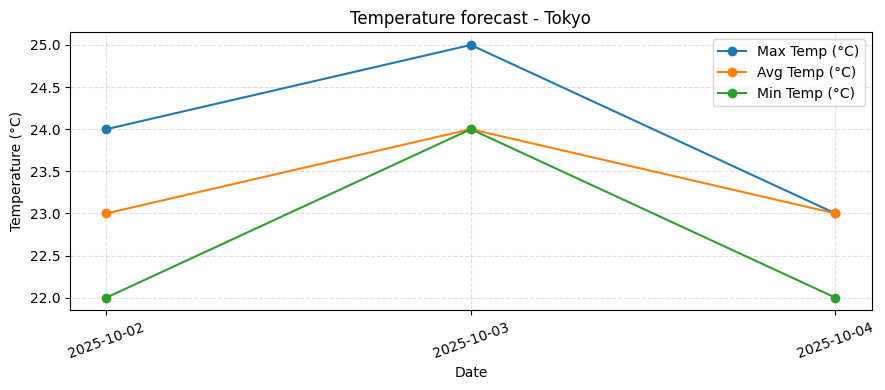

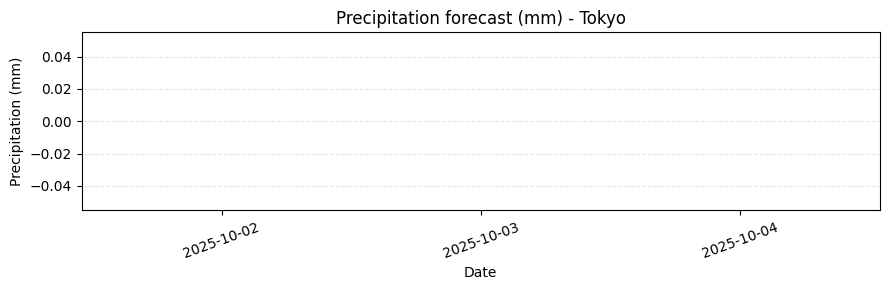


Q: Will it rain tomorrow in Dhaka?
Parsed: {'raw': 'Will it rain tomorrow in Dhaka?', 'location': 'Dhaka', 'time': 'tomorrow', 'attribute': 'precipitation'}
Response: In Dhaka on 2025-10-02: estimated precipitation is 0.0 mm. Unlikely to rain — umbrella probably not needed.

Q: What's the temperature in London today?
Parsed: {'raw': "What's the temperature in London today?", 'location': 'London', 'time': 'today', 'attribute': 'temperature'}
Response: In London on 2025-10-01: expected temperatures are 13.0°C — 18.0°C (min — max). The average is about 15.0°C.

Q: Should I take an umbrella on 2025-10-05 in New York?
Parsed: {'raw': 'Should I take an umbrella on 2025-10-05 in New York?', 'location': 'New York', 'time': '2025-10-05', 'attribute': 'precipitation'}
Response: In New York on 2025-10-01: estimated precipitation is 0.0 mm. Unlikely to rain — umbrella probably not needed.

Q: Is this weekend good for hiking in Tokyo?
Parsed: {'raw': 'Is this weekend good for hiking in Tokyo?', 'l

In [38]:
# Example 1: Fetch & visualise
w = run_fetch_and_show("Tokyo", days=3)

# Example 2: Parse some sample questions
samples = [
    "Will it rain tomorrow in Dhaka?",
    "What's the temperature in London today?",
    "Should I take an umbrella on 2025-10-05 in New York?",
    "Is this weekend good for hiking in Tokyo?"
]
for s in samples:
    parsed = parse_weather_question(s)
    resp = generate_weather_response(parsed, w if parsed.get('location') is None else get_weather_data(parsed.get('location'), forecast_days=3))
    print("\nQ:", s)
    print("Parsed:", parsed)
    print("Response:", resp)


## 🗂️ AI Prompting Log

### Conversation 1: Understanding Assignment Requirements
- **Prompt:** Asked AI to explain assignment requirements and clarify the role of `fetch-my-weather`, `ipywidgets`, and the `main()` function.  
- **Result:** Learned that `fetch-my-weather` is the preferred data provider but should fall back to `wttr.in` if unavailable. `ipywidgets` is required to build the interactive user interface. The `main()` function is not for end users but serves as a demo/test harness to show the system works without widgets, useful for grading.

---

### Conversation 2: Architectural Options
- **Prompt:** Asked AI about the main phases of the project and what architectural approaches would provide maximum modularity and robustness.  
- **Result:** AI outlined three approaches: (1) Modular Pipeline, (2) Conversational State, and (3) Data-First Visualization. I chose the Modular Pipeline, which enforces clean data contracts between modules (`parse_question`, `get_weather_data`, `generate_response`, `visualisations`). This approach improved modularity, clarity, and testability.

---

### Conversation 3: Data Retrieval Function (`get_weather_data`)
- **Prompt:** Asked to give me an organized function code, defining my expected output, regardless of whether the function uses the Python wrapper or falls back to raw wttr.in JSON.  
- **Result:** Received a reusable `get_weather_data` function that first tries `fetch-my-weather`, then falls back to `wttr.in`. The function always normalises the data into a consistent format (`location`, `current`, `forecast`, `source`) and includes error handling by returning `{'error': 'message'}` when data cannot be retrieved.

---

### Conversation 4: Error Handling for Invalid Locations
- **Prompt:** Asked AI how to fix a `NoneType` error when entering a gibberish location name such as "brosktl".  
- **Result:** Learned to update `get_weather_data` so it always returns a dict, and to add extra checks in `on_fetch_clicked` and `on_ask_clicked`. Now invalid locations return a clear error message like *Error: Failed to retrieve weather for 'jyfju'*

---

### Conversation 5: Precipitation Data Always Zero
- **Prompt:** Asked why precipitation values always showed `0.0 mm` regardless of location or days.  
- **Result:** Discovered that wttr.in often reports daily precipitation as `0.0`, but actual rain values are stored in the hourly data. The fix was to sum hourly precipitation values instead of averaging or relying on the daily field.

---

### Conversation 6: Debugging Utility Functions
- **Prompt:** Asked what the helper functions `safe_get` and `to_title` are for, and why I was getting a `NameError: Optional not defined`.  
- **Result:** Learned that `safe_get` is a safe way to access nested dict values without crashing, while `to_title` formats location names nicely. The `Optional` error was due to missing `from typing import Optional`. Adding the import (or removing the type hint) resolved the issue.